 ### Research Questions:
 1. Do pop artists exhibit different lexical complexity than alternative artists?
 2. Which specific complexity metrics show the strongest differences?
 3. Are different types of complexity related within songs?
 4. Are there significant differences in readability between groups?


In [6]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, levene, f_oneway, kruskal, mannwhitneyu, pearsonr, spearmanr
import textstat  # pip install textstat

current_dir = os.path.abspath("")
PROJECT_ROOT = os.path.dirname(current_dir)
DATA_PATH = os.path.join(PROJECT_ROOT, "data")
PROCESSED_PATH = os.path.join(DATA_PATH, "processed")

print(f"Project root: {PROJECT_ROOT}")
print(f"Processed data path: {PROCESSED_PATH}")

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

Project root: c:\Users\USER\Documents\GitHub\lyrics-analysis
Processed data path: c:\Users\USER\Documents\GitHub\lyrics-analysis\data\processed


In [9]:
def load_data():
    """Load the processed lyrics data"""
    # Try different possible file names
    possible_files = [
        "processed.csv",
        "all_songs_raw.csv",
    ]
    
    for filename in possible_files:
        filepath = os.path.join(PROCESSED_PATH, filename)
        if os.path.exists(filepath):
            print(f"Loading data from: {filepath}")
            df = pd.read_csv(filepath, encoding='utf-8')
            print(f"Successfully loaded {len(df)} songs")
            return df
    
    print("No data files found. Please run data collection first.")
    return None

df = load_data()

if df is not None:
    print(f"\nData shape: {df.shape}")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nFirst few rows:")
    display(df.head())

Loading data from: c:\Users\USER\Documents\GitHub\lyrics-analysis\data\processed\processed.csv
Successfully loaded 398 songs

Data shape: (398, 6)

Columns: ['artist', 'title', 'album', 'cleaned_lyrics', 'num_words', 'num_chars']

First few rows:


,artist,title,album,cleaned_lyrics,num_words,num_chars
0,Michael Jackson,Billie Jean,The Ultimate Fan Extras Collection,She was more like a beauty queen from a movie ...,592,2914
1,Michael Jackson,Smooth Criminal,The Indispensable Collection,Ow!\nCha!\nShoo-ca-choo-ca!\n\nAs he came into...,531,2835
2,Michael Jackson,Wanna Be Startin’ Somethin’,The Indispensable Collection,Ooh\n\nI said you wanna be startin' somethin'\...,964,5991
3,Michael Jackson,Heal the World,The Indispensable Collection,"Think about, um, the generations, and, uh, say...",625,3064
4,Michael Jackson,Thriller,The Indispensable Collection,It's close to midnight\nAnd something evil's l...,495,2781


In [10]:
# Define our artist groups for comparison
artist_groups = {
    'pop': [
        "Michael Jackson",
        "Taylor Swift",
        "The Beatles",
        "Prince",
        "Beyoncé",
        "Madonna",
        "Britney Spears",
        "Adele",
        "Whitney Houston",
        "Elton John"
        ],
    'alt': [   
        "Bob Dylan",
        "Neil Young",
        "Nick Cave & The Bad Seeds",
        "Joanna Newsom",
        "Joni Mitchell",
        "Sufjan Stevens",
        "Fiona Apple",
        "Kate Bush",
        "Tori Amos",
        "Carole King"
        ]
}

# Add group column to dataframe
def assign_group(artist):
    for group, artists in artist_groups.items():
        if artist in artists:
            return group
    return 'other'

df['group'] = df['artist'].apply(assign_group)

print("Artists by group:")
print(df['group'].value_counts())
print("\nSongs per artist:")
print(df['artist'].value_counts())

Artists by group:
group
pop    199
alt    199
Name: count, dtype: int64

Songs per artist:
artist
Michael Jackson              20
The Beatles                  20
Prince                       20
Beyoncé                      20
Nick Cave & The Bad Seeds    20
Madonna                      20
Britney Spears               20
Adele                        20
Whitney Houston              20
Elton John                   20
Bob Dylan                    20
Neil Young                   20
Kate Bush                    20
Joanna Newsom                20
Joni Mitchell                20
Sufjan Stevens               20
Carole King                  20
Tori Amos                    20
Taylor Swift                 19
Fiona Apple                  19
Name: count, dtype: int64


In [16]:
def calculate_complexity_metrics(text):
    """Calculate various readability and complexity metrics"""
    if not text or len(str(text).split()) < 10:  # Need enough text
        return {
            'flesch_reading_ease': np.nan,
            'flesch_kincaid_grade': np.nan,
            'gunning_fog': np.nan,
            'coleman_liau': np.nan,
            'automated_readability': np.nan,
            'dale_chall': np.nan,
            'linsear_write': np.nan,
            'text_standard': np.nan,
            'type_token_ratio': np.nan,
            'avg_sentence_length': np.nan
        }
    
    try:
        text_str = str(text)
        words = text_str.split()
        
        # Readability metrics
        flesch_ease = textstat.flesch_reading_ease(text_str)
        flesch_grade = textstat.flesch_kincaid_grade(text_str)
        gunning_fog = textstat.gunning_fog(text_str)
        coleman_liau = textstat.coleman_liau_index(text_str)
        automated_readability = textstat.automated_readability_index(text_str)
        dale_chall = textstat.dale_chall_readability_score(text_str)
        linsear_write = textstat.linsear_write_formula(text_str)
        text_standard = textstat.text_standard(text_str, float_output=True)
        
        # Lexical diversity
        unique_words = set(w.lower() for w in words)
        type_token_ratio = len(unique_words) / len(words) if len(words) > 0 else np.nan
        
        # Average sentence length (approximate)
        sentences = text_str.replace('!', '.').replace('?', '.').split('.')
        sentence_lengths = [len(s.split()) for s in sentences if s.strip()]
        avg_sentence_length = np.mean(sentence_lengths) if sentence_lengths else np.nan
        
        return {
            'flesch_reading_ease': flesch_ease,
            'flesch_kincaid_grade': flesch_grade,
            'gunning_fog': gunning_fog,
            'coleman_liau': coleman_liau,
            'automated_readability': automated_readability,
            'dale_chall': dale_chall,
            'linsear_write': linsear_write,
            'text_standard': text_standard,
            'type_token_ratio': type_token_ratio,
            'avg_sentence_length': avg_sentence_length
        }
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return {k: np.nan for k in ['flesch_reading_ease', 'flesch_kincaid_grade', 
                                   'gunning_fog', 'coleman_liau', 'type_token_ratio']}

# Apply to all songs 
results = df['cleaned_lyrics'].apply(calculate_complexity_metrics)
metrics = pd.DataFrame(results.tolist())

# Combine with original data
df_metrics = pd.concat([df, metrics], axis=1)

# Remove rows with missing complexity metrics
df_metrics = df_metrics.dropna(subset=['flesch_kincaid_grade', 'type_token_ratio'])

print(f"\nAfter complexity calculation: {len(df_metrics)} songs with valid metrics")

# Save the enriched data
output_file = os.path.join(PROCESSED_PATH, "lyrics_with_metrics.csv")
df_metrics.to_csv(output_file, index=False, encoding='utf-8')
print(f"Saved enriched data to: {output_file}")



After complexity calculation: 398 songs with valid metrics
Saved enriched data to: c:\Users\USER\Documents\GitHub\lyrics-analysis\data\processed\lyrics_with_metrics.csv


In [18]:
print("DESCRIPTIVE STATISTICS")

# Overall statistics
print("\nOverall Statistics (All Songs):")
overall_stats = df_metrics[['flesch_kincaid_grade', 'type_token_ratio', 
                           'gunning_fog', 'coleman_liau', 'avg_sentence_length']].describe()
print(overall_stats.round(3))

# By group
print("\n\nStatistics by Artist Group:")
group_stats = df_metrics.groupby('group').agg({
    'flesch_kincaid_grade': ['mean', 'std', 'count'],
    'type_token_ratio': ['mean', 'std'],
    'gunning_fog': ['mean', 'std'],
    'coleman_liau': ['mean', 'std'],
    'avg_sentence_length': ['mean', 'std']
}).round(3)

print(group_stats)

# By individual artist
print("\n\nStatistics by Individual Artist:")
artist_stats = df_metrics.groupby('artist').agg({
    'flesch_kincaid_grade': ['mean', 'std', 'count'],
    'type_token_ratio': ['mean', 'std'],
    'gunning_fog': ['mean', 'std']
}).round(3)

print(artist_stats)

DESCRIPTIVE STATISTICS

Overall Statistics (All Songs):
       flesch_kincaid_grade  type_token_ratio  gunning_fog  coleman_liau  \
count               398.000           398.000      398.000       398.000   
mean                 61.736             0.404       65.409         6.053   
std                  53.113             0.118       54.483         1.756   
min                   1.688             0.062        3.051         1.354   
25%                  20.211             0.325       23.085         4.863   
50%                  48.647             0.398       51.280         6.035   
75%                  89.589             0.476       93.971         7.040   
max                 379.909             0.785      391.108        12.818   

       avg_sentence_length  
count              398.000  
mean               158.650  
std                136.010  
min                  6.029  
25%                 52.865  
50%                122.750  
75%                233.000  
max                975.000 

In [21]:
print("ASSUMPTION CHECKING")

def check_assumptions(df, metric, group_col='group'):
    """Check normality and homogeneity of variance assumptions"""
    
    groups = df[group_col].unique()
    group_data = {}
    
    print(f"\nChecking assumptions for: {metric}")
    
    # Collect data for each group
    for group in groups:
        data = df[df[group_col] == group][metric].dropna()
        group_data[group] = data
        print(f"{group}: n = {len(data)}, mean = {data.mean():.3f}, std = {data.std():.3f}")
    
    # 1. Normality test (Shapiro-Wilk)
    print("\n1. Normality Test (Shapiro-Wilk):")
    normal = True
    for group, data in group_data.items():
        if len(data) >= 3 and len(data) <= 5000:  # Shapiro limitation
            stat, p = shapiro(data)
            print(f"  {group}: W = {stat:.3f}, p = {p:.4f} {'(normal)' if p > 0.05 else '*(not normal)*'}")
            if p < 0.05:
                normal = False
        else:
            print(f"  {group}: Sample size {len(data)} - skipping normality test")
    
    # 2. Homogeneity of variance (Levene's test)
    print("\n2. Homogeneity of Variance (Levene's test):")
    if len(groups) >= 2:
        data_lists = [group_data[g] for g in groups if len(group_data[g]) >= 2]
        if len(data_lists) >= 2:
            stat, p = levene(*data_lists)
            print(f"  Statistic = {stat:.3f}, p = {p:.4f}")
            print(f"  {'Variances are equal' if p > 0.05 else '*Variances are not equal*'}")
            equal_var = p > 0.05
        else:
            print("  Insufficient data for Levene's test")
            equal_var = None
    else:
        print("  Only one group - skipping Levene's test")
        equal_var = None
    
    return {
        'metric': metric,
        'normal': normal,
        'equal_variance': equal_var,
        'appropriate_test': 'parametric' if normal and (equal_var or equal_var is None) else 'nonparametric'
    }

# Check assumptions for key metrics
key_metrics = ['flesch_kincaid_grade', 'type_token_ratio', 'gunning_fog', 'coleman_liau']
assumption_results = []

for metric in key_metrics:
    result = check_assumptions(df_metrics, metric)
    assumption_results.append(result)

# Summary
print("\n" + "=" * 40)
print("TEST SELECTION SUMMARY")
print("=" * 40)
for result in assumption_results:
    test_type = "ANOVA/t-test" if result['appropriate_test'] == 'parametric' else "Kruskal-Wallis/Mann-Whitney"
    print(f"{result['metric']}: Use {test_type}")

ASSUMPTION CHECKING

Checking assumptions for: flesch_kincaid_grade
pop: n = 199, mean = 63.841, std = 56.550
alt: n = 199, mean = 59.631, std = 49.492

1. Normality Test (Shapiro-Wilk):
  pop: W = 0.860, p = 0.0000 *(not normal)*
  alt: W = 0.848, p = 0.0000 *(not normal)*

2. Homogeneity of Variance (Levene's test):
  Statistic = 1.831, p = 0.1767
  Variances are equal

Checking assumptions for: type_token_ratio
pop: n = 199, mean = 0.360, std = 0.093
alt: n = 199, mean = 0.448, std = 0.123

1. Normality Test (Shapiro-Wilk):
  pop: W = 0.968, p = 0.0002 *(not normal)*
  alt: W = 0.984, p = 0.0197 *(not normal)*

2. Homogeneity of Variance (Levene's test):
  Statistic = 10.904, p = 0.0010
  *Variances are not equal*

Checking assumptions for: gunning_fog
pop: n = 199, mean = 67.512, std = 58.054
alt: n = 199, mean = 63.305, std = 50.721

1. Normality Test (Shapiro-Wilk):
  pop: W = 0.860, p = 0.0000 *(not normal)*
  alt: W = 0.848, p = 0.0000 *(not normal)*

2. Homogeneity of Variance

In [24]:
print("STATISTICAL TESTS: GROUP COMPARISONS")

def perform_group_comparison(df, metric, group1='pop', group2='alt'):
    """Perform appropriate statistical test based on assumptions"""
    
    # Get data for each group
    data1 = df[df['group'] == group1][metric].dropna()
    data2 = df[df['group'] == group2][metric].dropna()
    
    if len(data1) < 2 or len(data2) < 2:
        print(f"Insufficient data for {metric}")
        return None
    
    print(f"\n{metric.replace('_', ' ').title()}:")
    print(f"  {group1}: n={len(data1)}, mean={data1.mean():.3f} ± {data1.std():.3f}")
    print(f"  {group2}: n={len(data2)}, mean={data2.mean():.3f} ± {data2.std():.3f}")
    
    # Check assumptions
    normal1 = shapiro(data1)[1] > 0.05 if 3 <= len(data1) <= 5000 else True
    normal2 = shapiro(data2)[1] > 0.05 if 3 <= len(data2) <= 5000 else True
    equal_var = levene(data1, data2)[1] > 0.05
    
    # Choose test
    if normal1 and normal2:
        # Parametric: Independent t-test
        t_stat, p_value = stats.ttest_ind(data1, data2, equal_var=equal_var)
        test_name = "Student's t-test" if equal_var else "Welch's t-test"
        
        # Effect size (Cohen's d)
        mean_diff = data1.mean() - data2.mean()
        n1, n2 = len(data1), len(data2)
        pooled_std = np.sqrt(((n1-1)*data1.std()**2 + (n2-1)*data2.std()**2) / (n1 + n2 - 2))
        cohens_d = mean_diff / pooled_std if pooled_std != 0 else 0
        
        effect_size = cohens_d
        effect_label = "Cohen's d"
        
    else:
        # Non-parametric: Mann-Whitney U test
        u_stat, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
        test_name = "Mann-Whitney U test"
        
        # Effect size (Rank-biserial correlation)
        n1, n2 = len(data1), len(data2)
        r_b = 1 - (2 * u_stat) / (n1 * n2)
        effect_size = r_b
        effect_label = "Rank-biserial r"
    
    # Determine significance
    alpha = 0.05
    significant = p_value < alpha
    
    # Interpretation
    if significant:
        if effect_size > 0:
            direction = f"{group1} > {group2}"
        else:
            direction = f"{group2} > {group1}"
    else:
        direction = "No significant difference"
    
    print(f"  Test: {test_name}")
    print(f"  p-value: {p_value:.4f}")
    print(f"  Significant (alpha={alpha}): {'Yes' if significant else 'No'}")
    print(f"  Effect size ({effect_label}): {effect_size:.3f}")
    print(f"  Direction: {direction}")
    
    return {
        'metric': metric,
        'group1': group1,
        'group2': group2,
        'test': test_name,
        'statistic': t_stat if 't-test' in test_name else u_stat,
        'p_value': p_value,
        'effect_size': effect_size,
        'effect_label': effect_label,
        'significant': significant,
        'direction': direction,
        'group1_mean': data1.mean(),
        'group2_mean': data2.mean(),
        'group1_std': data1.std(),
        'group2_std': data2.std(),
        'group1_n': len(data1),
        'group2_n': len(data2)
    }

# Perform comparisons for key metrics
comparison_results = []
for metric in key_metrics:
    result = perform_group_comparison(df_metrics, metric)
    if result:
        comparison_results.append(result)

# Create results DataFrame
results_df = pd.DataFrame(comparison_results)

print("\nSUMMARY OF GROUP COMPARISONS")
display(results_df[['metric', 'test', 'p_value', 'effect_size', 'significant', 'direction']])

STATISTICAL TESTS: GROUP COMPARISONS

Flesch Kincaid Grade:
  pop: n=199, mean=63.841 ± 56.550
  alt: n=199, mean=59.631 ± 49.492
  Test: Mann-Whitney U test
  p-value: 0.8180
  Significant (alpha=0.05): No
  Effect size (Rank-biserial r): -0.013
  Direction: No significant difference

Type Token Ratio:
  pop: n=199, mean=0.360 ± 0.093
  alt: n=199, mean=0.448 ± 0.123
  Test: Mann-Whitney U test
  p-value: 0.0000
  Significant (alpha=0.05): Yes
  Effect size (Rank-biserial r): 0.486
  Direction: pop > alt

Gunning Fog:
  pop: n=199, mean=67.512 ± 58.054
  alt: n=199, mean=63.305 ± 50.721
  Test: Mann-Whitney U test
  p-value: 0.8503
  Significant (alpha=0.05): No
  Effect size (Rank-biserial r): -0.011
  Direction: No significant difference

Coleman Liau:
  pop: n=199, mean=5.912 ± 1.812
  alt: n=199, mean=6.194 ± 1.692
  Test: Mann-Whitney U test
  p-value: 0.0352
  Significant (alpha=0.05): Yes
  Effect size (Rank-biserial r): 0.122
  Direction: pop > alt

SUMMARY OF GROUP COMPARISON

,metric,test,p_value,effect_size,significant,direction
0,flesch_kincaid_grade,Mann-Whitney U test,8.180394e-01,-0.013358,False,No significant difference
1,type_token_ratio,Mann-Whitney U test,4.734659e-17,0.486427,True,pop > alt
2,gunning_fog,Mann-Whitney U test,8.503493e-01,-0.010959,False,No significant difference
3,coleman_liau,Mann-Whitney U test,3.521297e-02,0.122068,True,pop > alt


In [25]:
print("EFFECT SIZE INTERPRETATION")

def interpret_effect_size(effect_size, effect_type):
    """Interpret the magnitude of effect size"""
    if effect_type == "Cohen's d":
        abs_d = abs(effect_size)
        if abs_d < 0.2:
            magnitude = "Negligible"
        elif abs_d < 0.5:
            magnitude = "Small"
        elif abs_d < 0.8:
            magnitude = "Medium"
        else:
            magnitude = "Large"
    else:  # Rank-biserial r
        abs_r = abs(effect_size)
        if abs_r < 0.1:
            magnitude = "Negligible"
        elif abs_r < 0.3:
            magnitude = "Small"
        elif abs_r < 0.5:
            magnitude = "Medium"
        else:
            magnitude = "Large"
    return magnitude

print("\nEffect Size Guidelines:")
print("Cohen's d: <0.2=Negligible, 0.2-0.5=Small, 0.5-0.8=Medium, >0.8=Large")
print("Rank-biserial r: <0.1=Negligible, 0.1-0.3=Small, 0.3-0.5=Medium, >0.5=Large")

print("\nInterpretation of Results:")
for _, row in results_df.iterrows():
    magnitude = interpret_effect_size(row['effect_size'], row['effect_label'])
    print(f"\n{row['metric']}:")
    print(f"  Effect size: {row['effect_size']:.3f} ({magnitude})")
    if row['significant']:
        print(f"  Conclusion: {row['direction']} with {magnitude.lower()} effect")
    else:
        print(f"  Conclusion: No significant difference")


EFFECT SIZE INTERPRETATION

Effect Size Guidelines:
Cohen's d: <0.2=Negligible, 0.2-0.5=Small, 0.5-0.8=Medium, >0.8=Large
Rank-biserial r: <0.1=Negligible, 0.1-0.3=Small, 0.3-0.5=Medium, >0.5=Large

Interpretation of Results:

flesch_kincaid_grade:
  Effect size: -0.013 (Negligible)
  Conclusion: No significant difference

type_token_ratio:
  Effect size: 0.486 (Medium)
  Conclusion: pop > alt with medium effect

gunning_fog:
  Effect size: -0.011 (Negligible)
  Conclusion: No significant difference

coleman_liau:
  Effect size: 0.122 (Small)
  Conclusion: pop > alt with small effect


In [26]:
print("CORRELATION ANALYSIS")

# Select metrics for correlation
correlation_metrics = ['flesch_kincaid_grade', 'type_token_ratio', 
                      'gunning_fog', 'coleman_liau', 'avg_sentence_length',
                      'flesch_reading_ease']

corr_df = df_metrics[correlation_metrics].dropna()

print(f"Sample size for correlation analysis: {len(corr_df)}")

# Calculate correlation matrix
print("\nPearson Correlation Matrix (Linear Relationships):")
pearson_corr = corr_df.corr(method='pearson')
display(pearson_corr.round(3))

print("\nSpearman Correlation Matrix (Monotonic Relationships):")
spearman_corr = corr_df.corr(method='spearman')
display(spearman_corr.round(3))

# Test specific correlations of interest
print("\nKey Correlation Tests:")
correlation_pairs = [
    ('flesch_kincaid_grade', 'type_token_ratio'),
    ('flesch_reading_ease', 'flesch_kincaid_grade'),
    ('type_token_ratio', 'avg_sentence_length'),
    ('gunning_fog', 'coleman_liau')
]

for var1, var2 in correlation_pairs:
    if var1 in corr_df.columns and var2 in corr_df.columns:
        data1 = corr_df[var1]
        data2 = corr_df[var2]
        
        # Pearson
        pearson_r, pearson_p = pearsonr(data1, data2)
        
        # Spearman
        spearman_rho, spearman_p = spearmanr(data1, data2)
        
        print(f"\n{var1} vs {var2}:")
        print(f"  Pearson: r = {pearson_r:.3f}, p = {pearson_p:.4f}")
        print(f"  Spearman: ρ = {spearman_rho:.3f}, p = {spearman_p:.4f}")
        
        # Interpret strength
        abs_r = abs(pearson_r)
        if abs_r >= 0.7:
            strength = "strong"
        elif abs_r >= 0.3:
            strength = "moderate"
        else:
            strength = "weak"
        
        print(f"  Interpretation: {strength} linear relationship")

CORRELATION ANALYSIS
Sample size for correlation analysis: 398

Pearson Correlation Matrix (Linear Relationships):


,flesch_kincaid_grade,type_token_ratio,gunning_fog,coleman_liau,avg_sentence_length,flesch_reading_ease
flesch_kincaid_grade,1.000,-0.311,1.000,0.160,0.992,-0.999
type_token_ratio,-0.311,1.000,-0.313,0.346,-0.307,0.305
gunning_fog,1.000,-0.313,1.000,0.156,0.992,-0.999
coleman_liau,0.160,0.346,0.156,1.000,0.149,-0.181
avg_sentence_length,0.992,-0.307,0.992,0.149,1.000,-0.991
flesch_reading_ease,-0.999,0.305,-0.999,-0.181,-0.991,1.000



Spearman Correlation Matrix (Monotonic Relationships):


,flesch_kincaid_grade,type_token_ratio,gunning_fog,coleman_liau,avg_sentence_length,flesch_reading_ease
flesch_kincaid_grade,1.000,-0.183,1.000,0.193,0.993,-0.999
type_token_ratio,-0.183,1.000,-0.186,0.361,-0.183,0.176
gunning_fog,1.000,-0.186,1.000,0.186,0.993,-0.998
coleman_liau,0.193,0.361,0.186,1.000,0.175,-0.220
avg_sentence_length,0.993,-0.183,0.993,0.175,1.000,-0.990
flesch_reading_ease,-0.999,0.176,-0.998,-0.220,-0.990,1.000



Key Correlation Tests:

flesch_kincaid_grade vs type_token_ratio:
  Pearson: r = -0.311, p = 0.0000
  Spearman: ρ = -0.183, p = 0.0003
  Interpretation: moderate linear relationship

flesch_reading_ease vs flesch_kincaid_grade:
  Pearson: r = -0.999, p = 0.0000
  Spearman: ρ = -0.999, p = 0.0000
  Interpretation: strong linear relationship

type_token_ratio vs avg_sentence_length:
  Pearson: r = -0.307, p = 0.0000
  Spearman: ρ = -0.183, p = 0.0002
  Interpretation: moderate linear relationship

gunning_fog vs coleman_liau:
  Pearson: r = 0.156, p = 0.0019
  Spearman: ρ = 0.186, p = 0.0002
  Interpretation: weak linear relationship


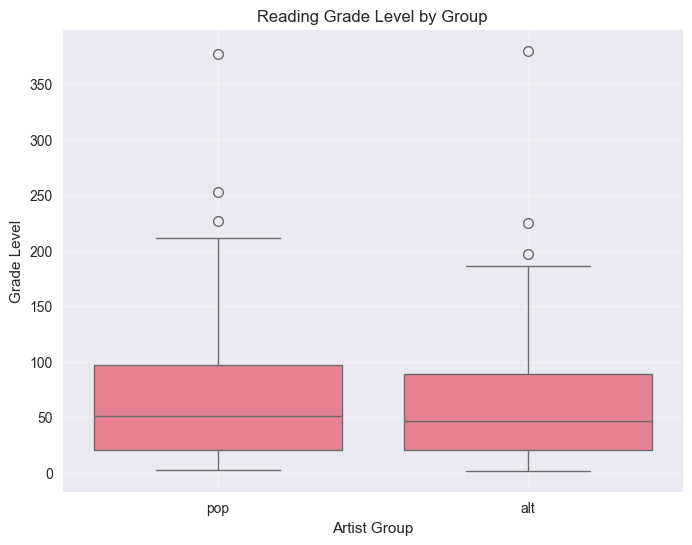

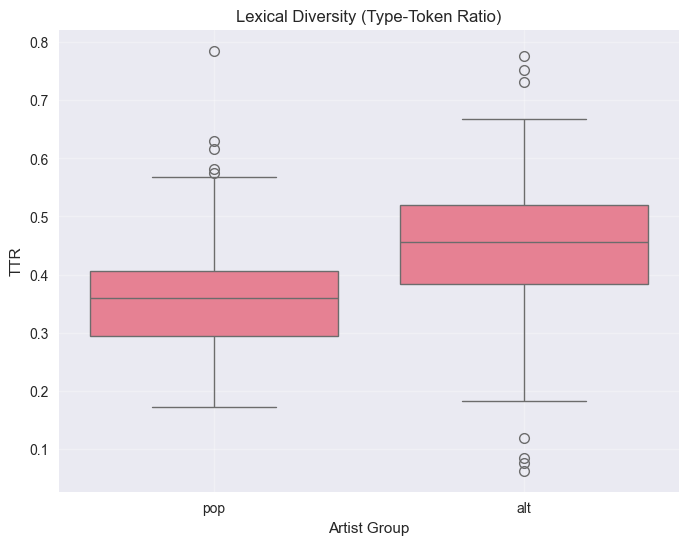

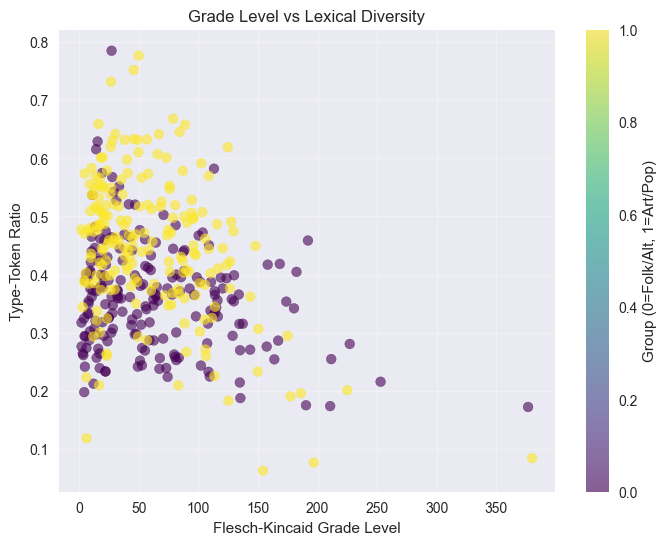

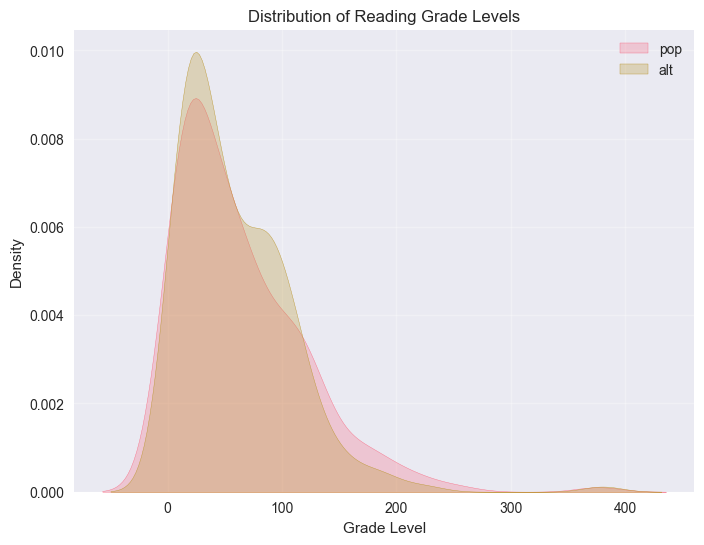

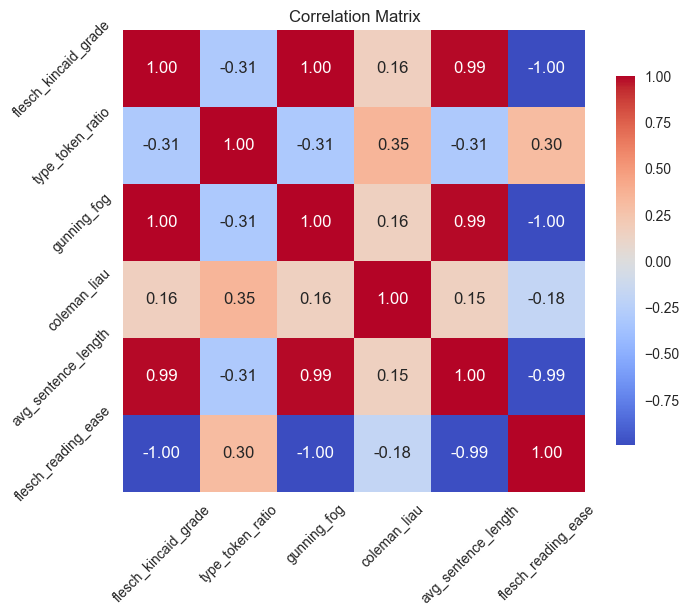

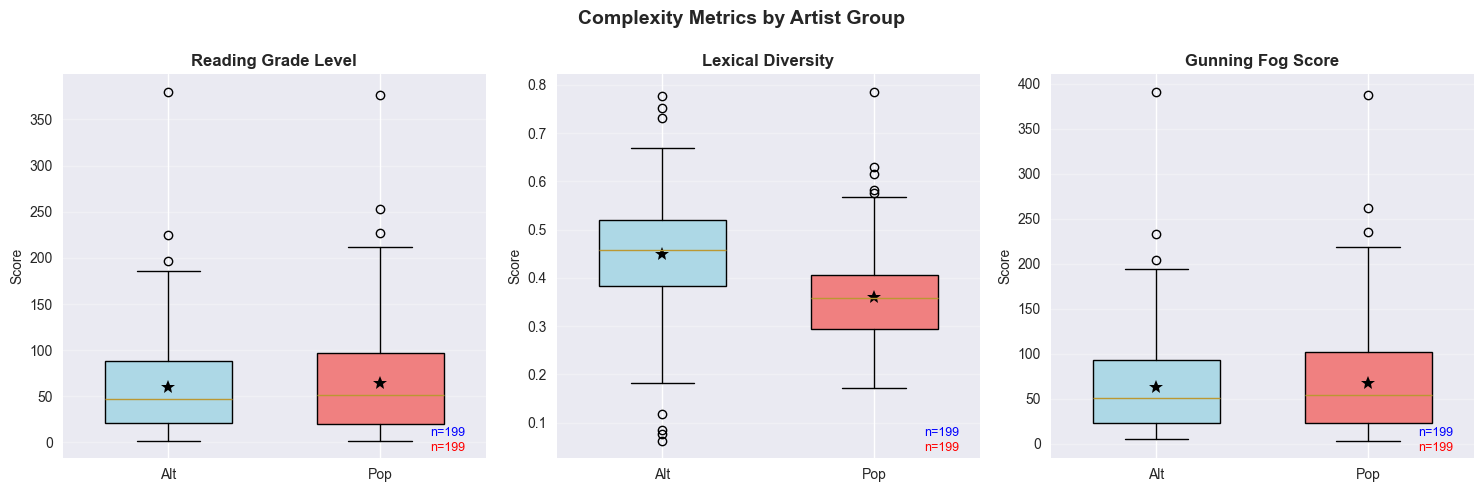

In [47]:
# Plot 1: Reading grade level by group
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df_metrics, x='group', y='flesch_kincaid_grade', ax=ax)
ax.set_title('Reading Grade Level by Group')
ax.set_xlabel('Artist Group')
ax.set_ylabel('Grade Level')
ax.grid(True, alpha=0.3)

# Add significance markers if significant
for idx, metric in enumerate(['flesch_kincaid_grade']):
    if 'results_df' in locals() and not results_df.empty:
        metric_results = results_df[results_df['metric'] == 'flesch_kincaid_grade']
        if not metric_results.empty:
            result = metric_results.iloc[0]  # Get first row
            if result['significant']:
                y_max = df_metrics['flesch_kincaid_grade'].max()
                ax.text(0.5, y_max * 1.05, '*', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.show()

# Plot 2: Lexical diversity by group
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df_metrics, x='group', y='type_token_ratio', ax=ax)
ax.set_title('Lexical Diversity (Type-Token Ratio)')
ax.set_xlabel('Artist Group')
ax.set_ylabel('TTR')
ax.grid(True, alpha=0.3)

plt.show()

# Plot 3: Correlation scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_metrics['flesch_kincaid_grade'], df_metrics['type_token_ratio'],
                     c=df_metrics['group'].map({'pop': 0, 'alt': 1}),
                     cmap='viridis', alpha=0.6, s=50)
ax.set_title('Grade Level vs Lexical Diversity')
ax.set_xlabel('Flesch-Kincaid Grade Level')
ax.set_ylabel('Type-Token Ratio')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Group (0=Folk/Alt, 1=Art/Pop)')

plt.show()

# Plot 4: Distribution comparison
fig, ax = plt.subplots(figsize=(8, 6))
for group in ['pop', 'alt']:
    data = df_metrics[df_metrics['group'] == group]['flesch_kincaid_grade'].dropna()
    sns.kdeplot(data=data, label=group, ax=ax, fill=True, alpha=0.3)
ax.set_title('Distribution of Reading Grade Levels')
ax.set_xlabel('Grade Level')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

# Plot 5: Heatmap of correlations
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(pearson_corr, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=ax, square=True, cbar_kws={'shrink': 0.8})
ax.set_title('Correlation Matrix')
ax.tick_params(rotation=45)

plt.show()

# Plot 6: Violin plot
# Plot 6: Separate subplots for each metric
metrics_to_plot = ['flesch_kincaid_grade', 'type_token_ratio', 'gunning_fog'][:3]  # First 3
fig6, axes6 = plt.subplots(1, len(metrics_to_plot), figsize=(15, 5))

# Metric names for display
metric_names = {
    'flesch_kincaid_grade': 'Reading Grade Level',
    'type_token_ratio': 'Lexical Diversity',
    'gunning_fog': 'Gunning Fog Score'
}

for idx, metric in enumerate(metrics_to_plot):
    ax = axes6[idx] if len(metrics_to_plot) > 1 else axes6
    
    # Get data for each group
    alt_data = df_metrics[df_metrics['group'] == 'alt'][metric].dropna()
    pop_data = df_metrics[df_metrics['group'] == 'pop'][metric].dropna()
    
    # Create box plot
    bp = ax.boxplot([alt_data, pop_data], 
                    tick_labels=['Alt', 'Pop'],
                    patch_artist=True,
                    widths=0.6)
    
    # Color the boxes
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    # Add mean markers
    ax.plot(1, alt_data.mean(), 'k*', markersize=10, label='Mean')
    ax.plot(2, pop_data.mean(), 'k*', markersize=10)
    
    # Titles and labels
    ax.set_title(metric_names.get(metric, metric), fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add sample size
    ax.text(0.95, 0.05, f'n={len(alt_data)}', transform=ax.transAxes, 
            ha='right', va='bottom', fontsize=9, color='blue')
    ax.text(0.95, 0.01, f'n={len(pop_data)}', transform=ax.transAxes, 
            ha='right', va='bottom', fontsize=9, color='red')

plt.suptitle('Complexity Metrics by Artist Group', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Add significance star if available
if 'results_df' in locals() and not results_df.empty:
    metric_results = results_df[results_df['metric'] == metric]
    if not metric_results.empty:
        result = metric_results.iloc[0]
        if result['significant']:
            y_max = max(alt_data.max(), pop_data.max())
            axes6.text(1.5, y_max * 1.05, '*', ha='center', va='bottom', 
                    fontsize=14, fontweight='bold')


In [61]:
# Save statistical results
results_file = os.path.join(PROCESSED_PATH, "statistical_results.csv")
results_df.to_csv(results_file, index=False, encoding='utf-8')
print(f"Saved statistical results to: {results_file}")

# Save correlation matrix
corr_file = os.path.join(PROCESSED_PATH, "correlation_matrix.csv")
pearson_corr.to_csv(corr_file, encoding='utf-8')
print(f"Saved correlation matrix to: {corr_file}")

# Generate text report
report_file = os.path.join(PROCESSED_PATH, "statistical_analysis_report.txt")

report = f"""
STATISTICAL ANALYSIS REPORT

Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
Total Songs Analyzed: {len(df_metrics)}
Songs by Group:
{df_metrics['group'].value_counts().to_string()}

RESEARCH QUESTIONS

1. Do pop artists exhibit different lexical complexity than alternative artists?
2. Which specific complexity metrics show the strongest differences?
3. Are different types of complexity related within songs?
4. Are there significant differences in readability between groups?

METHODOLOGY

Data Source: Genius.com API
Artists Analyzed:
  - Alternative: {', '.join(artist_groups['alt'])}
  - Pop: {', '.join(artist_groups['pop'])}

Complexity Metrics Calculated:
1. Flesch-Kincaid Grade Level
2. Type-Token Ratio (Lexical Diversity)
3. Gunning Fog Index
4. Coleman-Liau Index
5. Automated Readability Index
6. Average Sentence Length

Statistical Tests Applied:
- Shapiro-Wilk test for normality
- Levene's test for homogeneity of variance
- Independent t-test or Mann-Whitney U test for group comparisons
- Pearson and Spearman correlations
- Effect sizes (Cohen's d or Rank-biserial correlation)

RESULTS SUMMARY
"""

# Add group comparison results
report += "\nGROUP COMPARISON RESULTS:\n"
for _, row in results_df.iterrows():
    sig = "significant" if row['significant'] else "not significant"
    report += f"\n{row['metric'].replace('_', ' ').title()}:\n"
    report += f"  {sig} (p = {row['p_value']:.4f})\n"
    report += f"  Effect size ({row['effect_label']}): {row['effect_size']:.3f}\n"
    report += f"  Direction: {row['direction']}\n"
    report += f"  {row['group1']}: {row['group1_mean']:.2f} ± {row['group1_std']:.2f} (n={row['group1_n']})\n"
    report += f"  {row['group2']}: {row['group2_mean']:.2f} ± {row['group2_std']:.2f} (n={row['group2_n']})\n"

# Add correlation results
report += "\nCORRELATION FINDINGS:\n"
for var1, var2 in correlation_pairs:
    if var1 in corr_df.columns and var2 in corr_df.columns:
        pearson_r, pearson_p = pearsonr(corr_df[var1], corr_df[var2])
        spearman_rho, spearman_p = spearmanr(corr_df[var1], corr_df[var2])
        
        report += f"\n{var1} vs {var2}:\n"
        report += f"  Pearson r = {pearson_r:.3f} (p = {pearson_p:.4f})\n"
        report += f"  Spearman ρ = {spearman_rho:.3f} (p = {spearman_p:.4f})\n"

# Add interpretation
report += f"""

INTERPRETATION OF RESEARCH QUESTIONS

"""

# Answer RQ1
report += "1. Do pop artists exhibit different lexical complexity than alternative artists?\n"
sig_results = results_df[results_df['significant'] == True]
if len(sig_results) > 0:
    report += f"   {len(sig_results)}/{len(results_df)} metrics show significant differences:\n"
    for _, row in sig_results.iterrows():
        metric_name = row['metric'].replace('_', ' ').title()
        report += f"   - {metric_name}: {row['direction']} (p={row['p_value']:.4f})\n"
else:
    report += "   No statistically significant differences found at alpha=0.05\n"

# Answer RQ2
report += "\n2. Which specific complexity metrics show the strongest differences?\n"
if len(results_df) > 0:
    # Add absolute effect size for ranking
    results_df['abs_effect'] = abs(results_df['effect_size'])
    strongest = results_df.sort_values('abs_effect', ascending=False)

    report += "   Ranked by effect size (strongest first):\n"
    for _, row in strongest.iterrows():
        metric_name = row['metric'].replace('_', ' ').title()
        magnitude = "large" if abs(row['effect_size']) > 0.5 else "medium" if abs(row['effect_size']) > 0.2 else "small"
        report += f"   - {metric_name}: {row['effect_label']} = {row['effect_size']:.2f} ({magnitude} effect)\n"

# Answer RQ3
report += "\n3. Are different types of complexity related within songs?\n"
report += "   Key correlations between metrics:\n"
if 'pearson_corr' in locals():
    # Check key correlations
    key_pairs = [('flesch_kincaid_grade', 'gunning_fog'),
                 ('flesch_kincaid_grade', 'type_token_ratio'),
                 ('type_token_ratio', 'gunning_fog')]
for var1, var2 in key_pairs:
    if var1 in pearson_corr.index and var2 in pearson_corr.columns:
        r = pearson_corr.loc[var1, var2]
        strength = "strong" if abs(r) > 0.7 else "moderate" if abs(r) > 0.3 else "weak"
        direction = "positive" if r > 0 else "negative"
        
        var1_name = var1.replace('_', ' ').title()
        var2_name = var2.replace('_', ' ').title()
        report += f"   - {var1_name} & {var2_name}: r = {r:.2f} ({strength} {direction} correlation)\n"

# Answer RQ4
report += "\n4. Are there significant differences in readability between groups?\n"
readability_metrics = ['flesch_kincaid_grade', 'gunning_fog', 'coleman_liau', 
                       'automated_readability', 'dale_chall', 'linsear_write']

# Filter to readability metrics that exist in results
readability_results = results_df[results_df['metric'].isin(readability_metrics)]

if len(readability_results) > 0:
    sig_readability = readability_results[readability_results['significant'] == True]
    
    if len(sig_readability) > 0:
        report += f"   {len(sig_readability)}/{len(readability_results)} readability metrics differ:\n"
        for _, row in sig_readability.iterrows():
            metric_name = row['metric'].replace('_', ' ').title()
            report += f"   - {metric_name}: {row['direction']} (p={row['p_value']:.4f})\n"
    else:
        report += f"0/{len(readability_results)} readability metrics show significant differences\n"
else:
    print("No readability metrics available in results")

# Add conclusions
report += f"""

CONCLUSIONS

Based on the analysis of {len(df_metrics)} songs:

"""

# Generate conclusions
significant_findings = results_df[results_df['significant']]
if len(significant_findings) > 0:
    report += "Significant differences found:\n"
    for _, row in significant_findings.iterrows():
        magnitude = interpret_effect_size(row['effect_size'], row['effect_label'])
        report += f"   - {row['metric'].replace('_', ' ').title()}: {row['direction']} ({magnitude.lower()} effect)\n"
else:
    report += "No statistically significant differences found between artist groups.\n"

report += f"""

RECOMMENDATIONS FOR FURTHER RESEARCH

1. Increase sample size for more statistical power
2. Include more artists in each genre category
3. Analyze trends over time within artists' careers
4. Include additional linguistic features (syntactic complexity, semantic analysis)
5. Compare with broader music genres for context
"""

with open(report_file, 'w', encoding='utf-8') as f:
    f.write(report)

print(f"Generated report: {report_file}")

Saved statistical results to: c:\Users\USER\Documents\GitHub\lyrics-analysis\data\processed\statistical_results.csv
Saved correlation matrix to: c:\Users\USER\Documents\GitHub\lyrics-analysis\data\processed\correlation_matrix.csv
Generated report: c:\Users\USER\Documents\GitHub\lyrics-analysis\data\processed\statistical_analysis_report.txt
